In [38]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
%run ../../scripts/model_prediction_analyses.py

## Load the metadata for the reference `V7 combined` composite dataset (GSE42861, GSE125105, GSE72774, GSE106648) and separate it by healthy and disease cohorts

In [39]:
v7_meta = pd.read_excel('../../data/processed/metadata/V7_pmeta.xlsx')
h_meta = v7_meta.copy()
d_meta = v7_meta.copy()
h_meta = h_meta[h_meta.disease==0]
d_meta = d_meta[d_meta.disease==1]
h_meta.reset_index(drop=True, inplace=True)
d_meta.reset_index(drop=True, inplace=True)

## Load the AdaptAge model and the beta values of the healthy cohort of the V7 combined dataset filtered on the AdaptAge model's CpG selection

In [40]:
# Load the model
adapt = pd.read_csv('../../data/processed/models/AdaptAge/AdaptAge.csv')

# Read in the healthy cohort of the V7 combined dataset filtered on the AdaptAge model's CpG selection
h_adapt = pd.read_pickle('../../data/processed/models/AdaptAge/Healthy.pkl')

## Get the AdaptAge prediction residuals for the V7 healthy cohort, compute the summary statistics for the residuals and fit a normal distribution to the residuals. All of this data will later be used to generate Figure 2, Supplementary Figure 2 and Table 1

In [41]:
# Prep the AdaptAge model, giving it the right column names and CpG order matching that of the dataset
adapt=prep_model(adapt)

help(prep_model)

Help on function prep_model in module utils.data_processing:

prep_model(model)
    Prepare a model for making predictions.
    
    This function expects a DataFrame with two columns:
    - The first column should contain the CpG sites for the model.
    - The second column should contain the corresponding weights or importance scores.
    
    The function renames the columns to 'CpG' and 'Weight' and sorts the DataFrame
    by the 'CpG' column.
    
    Parameters:
    data (pd.DataFrame): The input DataFrame containing the model features and their weights.
    
    Returns:
    pd.DataFrame: The processed DataFrame with columns renamed and sorted by 'CpG'.



In [42]:
# Get the AdaptAge predictions
adapt_preds = get_preds(h_adapt, adapt) 

# help(get_preds)

In [43]:
# Calculate the residuals
adapt_resids = get_residuals(adapt_preds, h_meta,'AdaptAge')

# help(get_residuals)

In [44]:
# Calculate the mean and standard deviation of the residuals
mu, std = get_mu_std(adapt_resids)

# help(get_mu_std)

In [45]:
# Calculate the thresholds for the 95% interpercentile range (95-IPR) of a normal distribution fit to the residuals
cutoffs = get_cutoffs(mu, std)

# help(get_cutoffs)

In [46]:
# Generate the PDF for the AdaptAge residuals for the V7 healhty cohort
h_adapt_dist = create_residual_distribution(adapt_resids, mu, std, 'AdaptAge')

# help(create_residual_distribution)

In [47]:
# Compile the summary statistics for the AdaptAge residuals for the V7 healthy cohort
h_adapt_stats = [('AdaptAge',cutoffs[0], cutoffs[1], round(mu, 2))]

## The model_errs_and_dist function performs all of the above. Use it to generate the distribution and summary statistics for the other models for healthy and patient cohorts

In [48]:
# Load the other models
horvath = pd.read_excel('../../data/processed/models/Horvath/Horvath model.xlsx')
hannum = pd.read_excel('../../data/processed/models/Hannum/Hannum model.xlsx')
pheno = pd.read_csv('../../data/processed/models/PhenoAge/PhenoAge.csv')
dam = pd.read_csv('../../data/processed/models/DamAge/DamAge.csv')
caus = pd.read_csv('../../data/processed/models/CausAge/CausAge.csv')

# Read in the healthy cohort of the V7 combined dataset filtered on the respective models' CpG selections
h_horvath = pd.read_pickle('../../data/processed/models/Horvath/Healthy.pkl')
h_hannum = pd.read_pickle('../../data/processed/models/Hannum/Healthy.pkl')
h_pheno = pd.read_pickle('../../data/processed/models/PhenoAge/Healthy.pkl')
h_dam = pd.read_pickle('../../data/processed/models/DamAge/Healthy.pkl')
h_caus = pd.read_pickle('../../data/processed/models/CausAge/Healthy.pkl')

In [49]:
# Read in the patient cohort of the V7 combined dataset filtered on the respective models' CpG selections
d_horvath = pd.read_pickle('../../data/processed/models/Horvath/Disease.pkl')
d_hannum = pd.read_pickle('../../data/processed/models/Hannum/Disease.pkl')
d_pheno = pd.read_pickle('../../data/processed/models/PhenoAge/Disease.pkl')
d_adapt = pd.read_pickle('../../data/processed/models/AdaptAge/Disease.pkl')
d_dam = pd.read_pickle('../../data/processed/models/DamAge/Disease.pkl')
d_caus = pd.read_pickle('../../data/processed/models/CausAge/Disease.pkl')

In [50]:
# Get the summary statistics and distributions for the healthy cohorts of the other models
h_horvath_stats, h_horvath_dist = model_errs_and_dist(h_horvath, h_meta, horvath, 'Horvath', horvath_model=True)
h_hannum_stats, h_hannum_dist = model_errs_and_dist(h_hannum, h_meta, hannum, 'Hannum')
h_pheno_stats, h_pheno_dist = model_errs_and_dist(h_pheno, h_meta, pheno, 'PhenoAge')
h_dam_stats, h_dam_dist = model_errs_and_dist(h_dam, h_meta, dam, 'DamAge')
h_caus_stats, h_caus_dist = model_errs_and_dist(h_caus, h_meta, caus, 'CausAge')

In [51]:
# Get the summary statistics and distributions for the patient cohorts of the other models
d_horvath_stats, d_horvath_dist = model_errs_and_dist(d_horvath, d_meta, horvath, 'Horvath', horvath_model=True)
d_hannum_stats, d_hannum_dist = model_errs_and_dist(d_hannum, d_meta, hannum, 'Hannum')
d_pheno_stats, d_pheno_dist = model_errs_and_dist(d_pheno, d_meta, pheno, 'PhenoAge')
d_adapt_stats, d_adapt_dist = model_errs_and_dist(d_adapt, d_meta, adapt, 'AdaptAge')
d_dam_stats, d_dam_dist = model_errs_and_dist(d_dam, d_meta, dam, 'DamAge')
d_caus_stats, d_caus_dist = model_errs_and_dist(d_caus, d_meta, caus, 'CausAge')

# Generate Figure 2a

In [52]:
# create custom color palette
c_palette = sns.color_palette()
custom = c_palette[:3] + [c_palette[4]]+[c_palette[6]]+ c_palette[9:]

# concatenate the residual distributions for each model into a single dataframe
h_model_errors = pd.concat([h_horvath_dist, h_hannum_dist, h_pheno_dist, h_adapt_dist, h_dam_dist, h_caus_dist], axis=0)

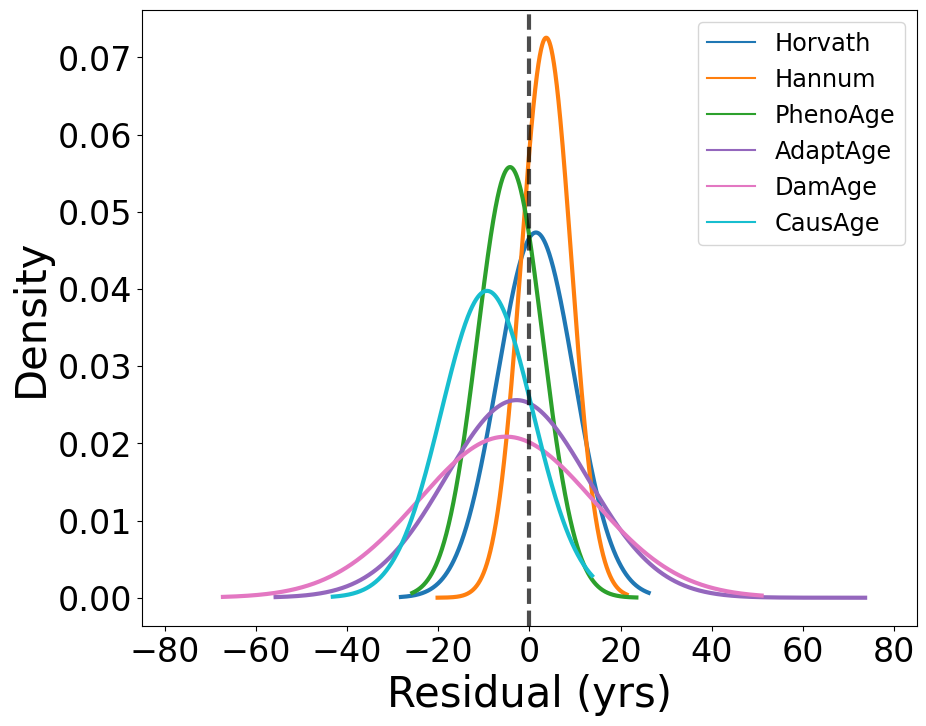

In [53]:
plt.figure(figsize=(10, 8)) 

sns.lineplot(h_model_errors, x='Error', y='Density', hue='Model', palette=custom, linewidth=3)
plt.axvline(x=0, color='black', linestyle='--', alpha=0.7, linewidth=3)

plt.xlim([-85,85])
plt.xlabel('Residual (yrs)',fontsize=30)
plt.ylabel('Density',fontsize=30)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize='xx-large', title_fontsize='50');

# Generate Figure 2b

In [54]:
# concatenate the residual distributions for each model into a single dataframe
d_model_errors = pd.concat([d_horvath_dist, d_hannum_dist, d_pheno_dist, d_adapt_dist, d_dam_dist, d_caus_dist], axis=0)

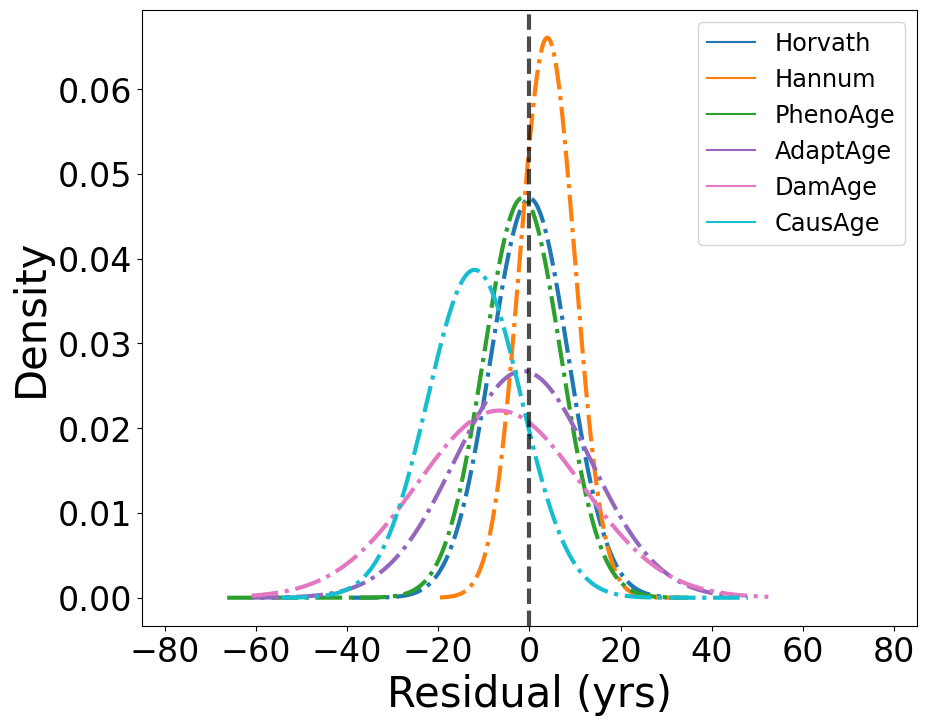

In [55]:
plt.figure(figsize=(10, 8)) 

sns.lineplot(d_model_errors, x='Error', y='Density', hue='Model', linestyle='-.', palette=custom, linewidth=3)
plt.axvline(x=0, color='black', linestyle='--', alpha=0.7, linewidth=3)

plt.xlim([-85,85])
plt.xlabel('Residual (yrs)',fontsize=30)
plt.ylabel('Density',fontsize=30)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize='xx-large', title_fontsize='50');

### Combine the model predictions and residuals into single dataframe

In [56]:
models = ['Horvath', 'Hannum', 'PhenoAge', 'AdaptAge', 'DamAge', 'CausAge']
comb_meta = pd.concat([h_meta,d_meta], axis=0)
hvd =  comb_meta[['age','disease']+models].copy()
# Melt the DataFrame
melted_df = pd.melt(hvd, id_vars=['age', 'disease'], var_name='Model', value_name='Prediction')
melted_df['Residual'] = melted_df.Prediction-melted_df.age

### Calculate the significances & effect size (Cohen's d) for each model's health v. disease cohort residuals comparison

In [65]:
significances = []
sig_key = {(0.05,1):'n.s.',
           (0.01,0.05):'*',
           (0.001,0.01):'**',
           (0, 0.001):'***'}

for model in melted_df.Model.unique():
    
    temp = melted_df[melted_df.Model==model]
    
    h_resids = temp[temp.disease==0].Residual
    d_resids = temp[temp.disease==1].Residual
    # Perform the Welch's t-test (independent t-test with unequal variances)
    statistic, p_value = ttest_ind(h_resids, d_resids, equal_var=False)
    d = cohens_d(h_resids,d_resids)
    
    for range_, sig_symbol in sig_key.items():
        if range_[0] <= p_value < range_[1]:
            sig = sig_symbol
    
    significances +=[[model, p_value, sig, d]]

# Generate Figure 2c

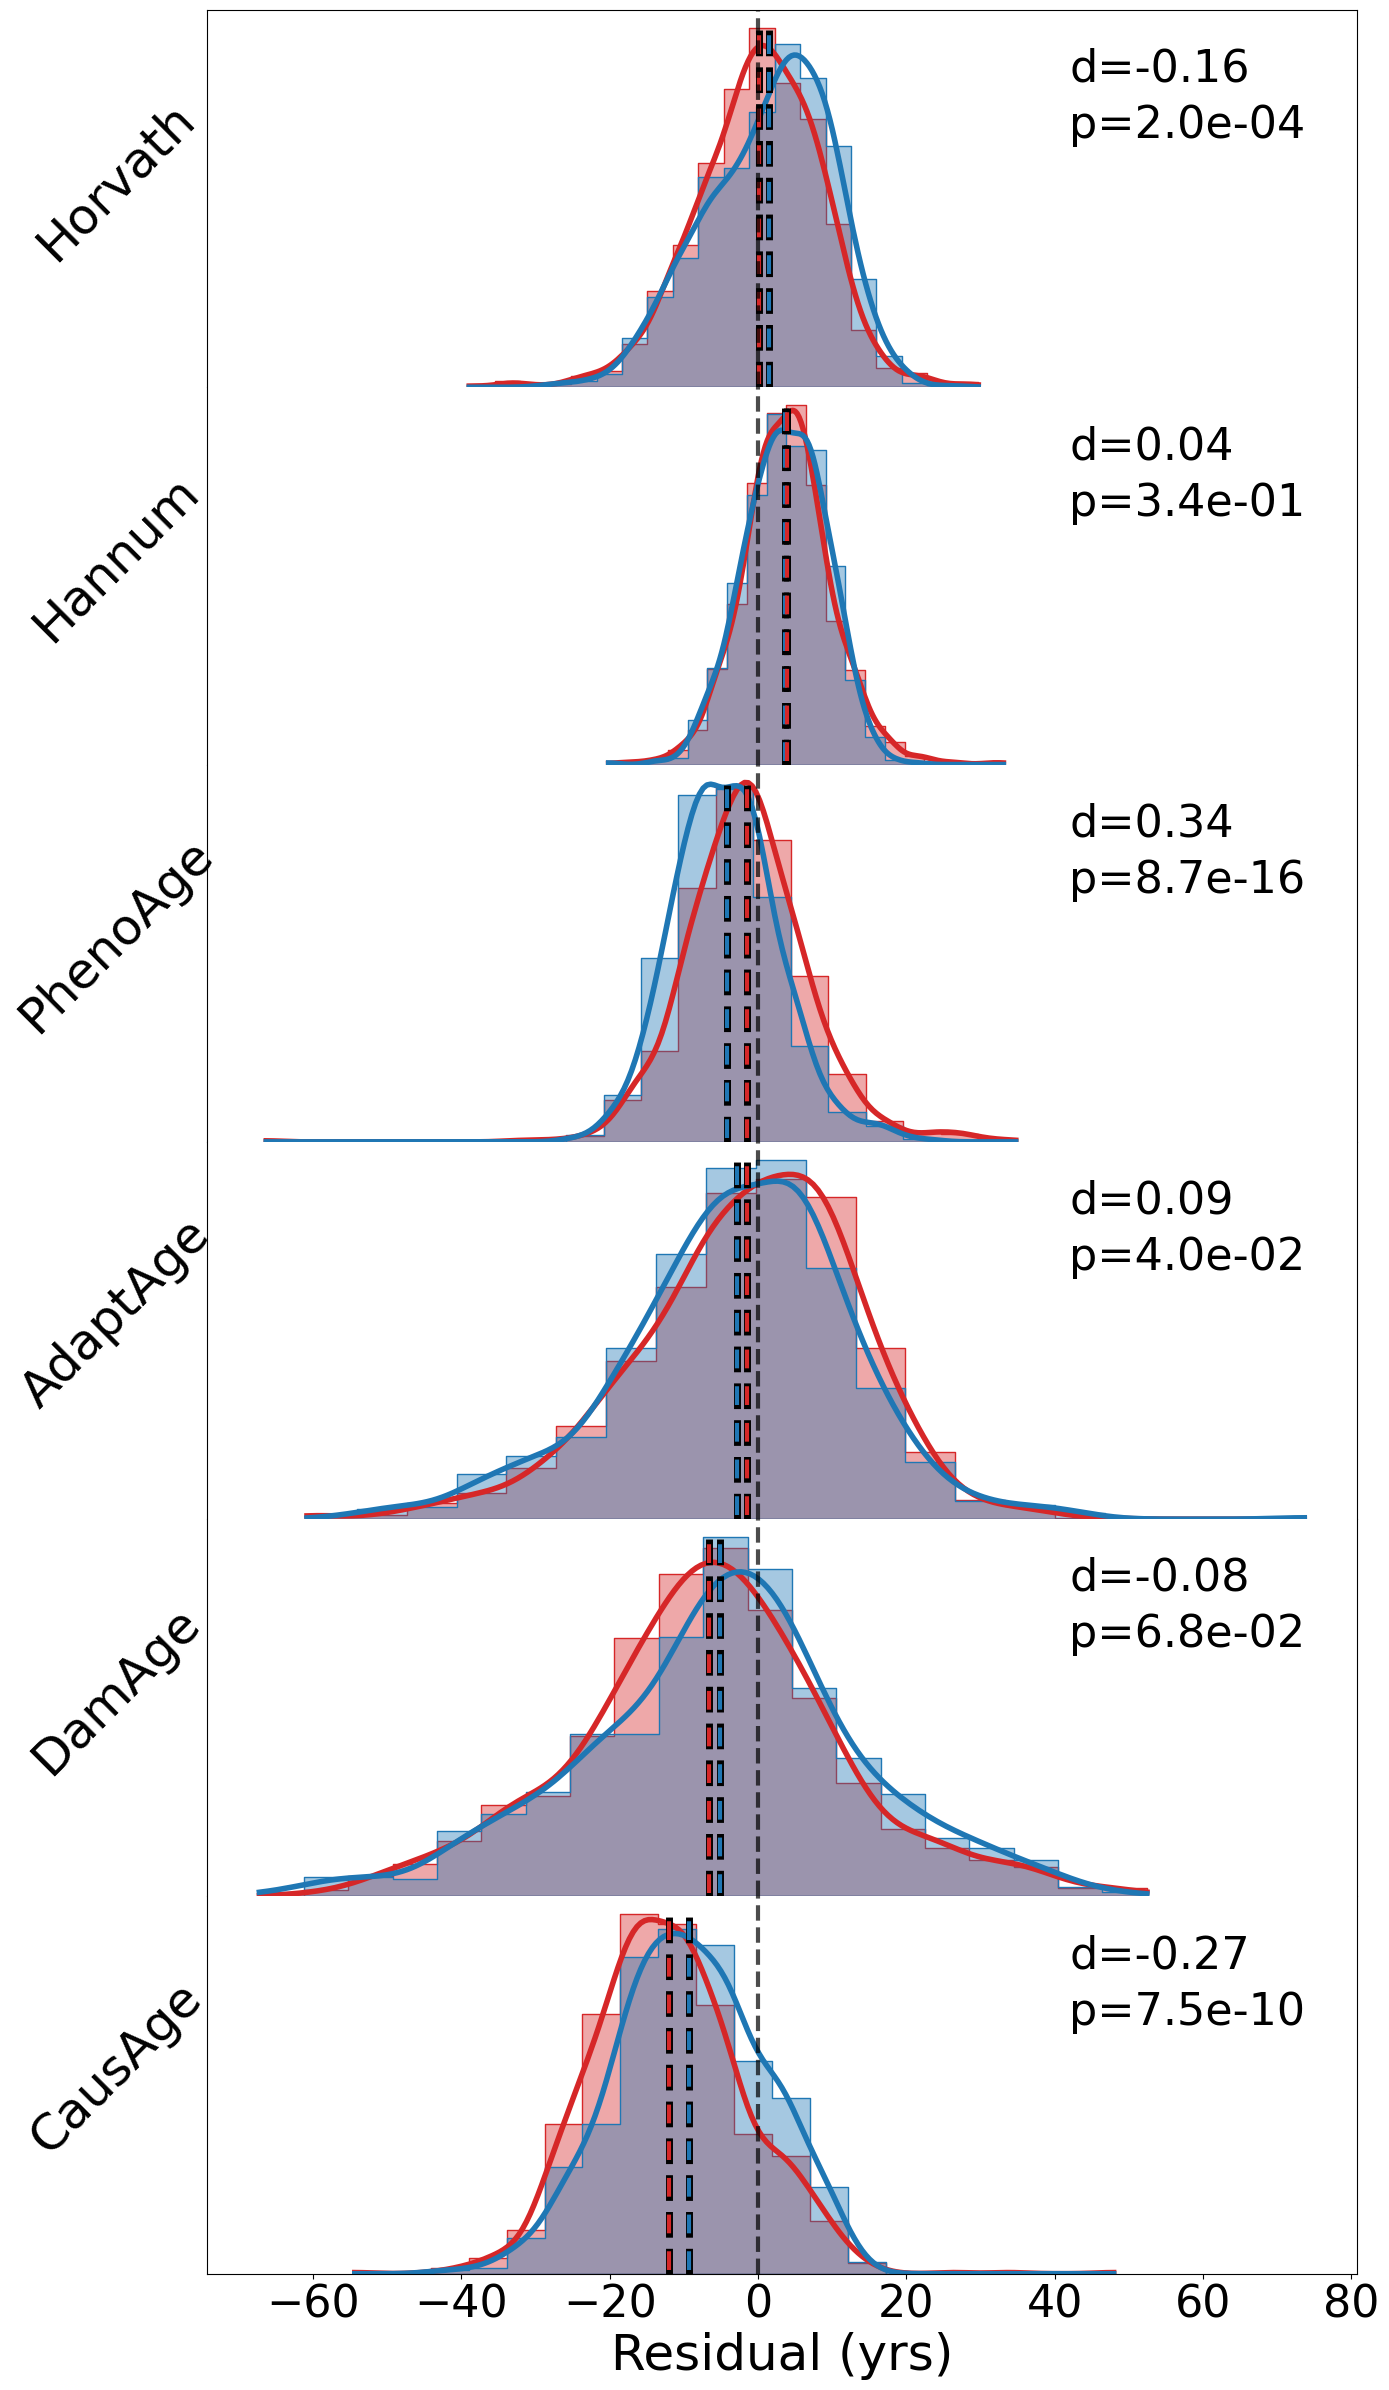

In [67]:
# Function to get significance and Cohen's d from the significances list for plotting
def get_significance_info(model, significances):
    for item in significances:
        if item[0] == model:
            p_value, significance, cohen_d = item[1], item[2], item[3]
            return p_value, significance, cohen_d
    return None, None, None

# Assuming melted_df is your DataFrame with columns 'Model', 'Residual', and 'disease'
# Define the models you want to compare
models = melted_df['Model'].unique()
disease_statuses = melted_df['disease'].unique()

# Create a single figure with multiple subplots arranged vertically
fig, axes = plt.subplots(nrows=len(models), ncols=1, figsize=(14, len(models) * 4), sharex=True, gridspec_kw={'hspace': 0})

# Define custom palette
blue = sns.color_palette()[0]
red = sns.color_palette()[3]
custom_palette = {disease_statuses[0]: blue, disease_statuses[1]: red}

for i, model in enumerate(models):
    ax = axes[i]  # Get the specific subplot
    model_data = melted_df[melted_df['Model'] == model]

    sns.histplot(
        data=model_data,
        x='Residual',
        hue='disease',
        palette=custom_palette,
        bins=20,
        kde=True,
        alpha=0.4,
        ax=ax,
        legend=False,
        element="step",
        stat="density",  # Normalize to percentage
        common_norm=False,  # Ensures separate normalization for each hue level
        line_kws={'linewidth': 4}
    )
    
    # Set model name as y-axis label
    ax.set_ylabel(f'{model}', fontsize=36, rotation=45, labelpad=50)
    ax.set_xlabel('Residual (yrs)', fontsize=36)

    # Remove density tick marks and density axis label
    ax.yaxis.set_ticks([])
    ax.set_yticklabels([])
    
    # Adjust the fontsize of the x-ticks for residuals
    ax.tick_params(axis='x', labelsize=32)

    # Plot means for each cohort (disease status)
    mean_disease = model_data[model_data['disease'] == disease_statuses[0]]['Residual'].mean()
    mean_undisease = model_data[model_data['disease'] == disease_statuses[1]]['Residual'].mean()
    ax.axvline(x=mean_disease, color=blue, linestyle='--', linewidth=3, label=f'Mean {disease_statuses[0]}',
               ymin=0.01, ymax=0.95, dashes=(4.5, 4.3), zorder=6)
    ax.axvline(x=mean_disease, color='k', linestyle='--', linewidth=5, ymax=0.95, label=f'Mean {disease_statuses[0]}')
    
    ax.axvline(x=mean_undisease, color=red, linestyle='--', linewidth=3, label=f'Mean {disease_statuses[1]}',
               ymin=0.01, ymax=0.95, dashes=(4.5, 4.3), zorder=6)
    ax.axvline(x=mean_undisease, color='k', linestyle='--', linewidth=5, ymax=0.95, label=f'Mean {disease_statuses[1]}')

    # Get precomputed p-value, significance, and Cohen's d
    p_value, significance, cohen_d = get_significance_info(model, significances)
    
    # Annotate Cohen's d on the plot using the Axes object
    if p_value is not None and significance is not None and cohen_d is not None:
        ax.text(0.75, 0.9, f"d={cohen_d:.2f}", transform=ax.transAxes, fontsize=32, verticalalignment='top')
        ax.text(0.75, 0.75, f"p={p_value:.1e}", transform=ax.transAxes, fontsize=32, verticalalignment='top')

    # Remove top and bottom borders for all but the first and last plot
    if i != 0:
        ax.spines['top'].set_visible(False)
    if i != len(models) - 1:
        ax.spines['bottom'].set_visible(False)

# Adjust layout to ensure everything fits without overlap
plt.tight_layout()

# Add a dashed vertical line at x=0 on all subplots
for ax in axes:
    ax.axvline(x=0, color='black', linestyle='--', alpha=0.7, linewidth=3, zorder=10)